In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta


In [2]:
# ------------------------------
# 1. Load CSV / OHLCV
# ------------------------------
df = pd.read_csv("btc_1h.csv")
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)


In [3]:
# ------------------------------
# 2. Calculate Parabolic SAR
# ------------------------------
df['PSAR'] = ta.trend.PSARIndicator(
    high=df['High'], low=df['Low'], close=df['Close'], step=0.02, max_step=0.2
).psar()

/home/gregory/Trading_bot/venv/lib/python3.12/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


In [4]:
# ------------------------------
# 3. Swing High/Low Labels
# ------------------------------
lookback = 5  # number of candles before and after for swing detection

def detect_swings(prices, highs, lows, lookback=5):
    labels = np.zeros(len(prices))
    for i in range(lookback, len(prices) - lookback):
        # Swing High → downtrend reversal
        if highs[i] == max(highs[i-lookback:i+lookback+1]):
            labels[i] = -1
        # Swing Low → uptrend reversal
        elif lows[i] == min(lows[i-lookback:i+lookback+1]):
            labels[i] = 1
    return labels

df['Label'] = detect_swings(df['Close'], df['High'], df['Low'], lookback=lookback)


/tmp/ipykernel_8249/189683862.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if highs[i] == max(highs[i-lookback:i+lookback+1]):
/tmp/ipykernel_8249/189683862.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif lows[i] == min(lows[i-lookback:i+lookback+1]):


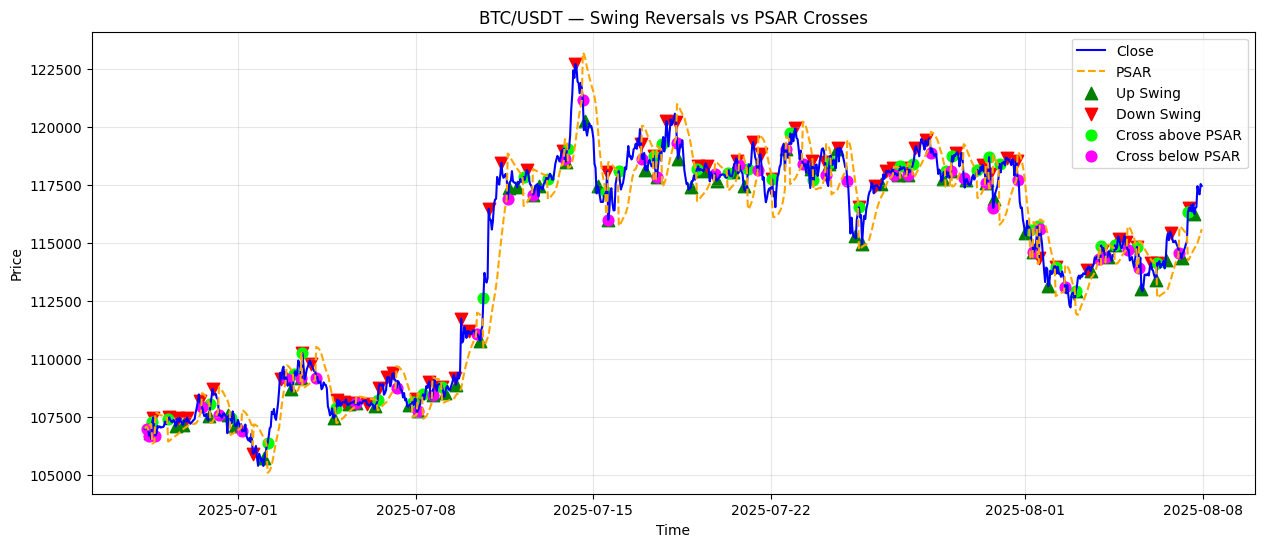

In [5]:
# ------------------------------
# 4. Visualization
# ------------------------------
plt.figure(figsize=(15,6))
plt.plot(df['Close'], label='Close', color='blue')
plt.plot(df['PSAR'], label='PSAR', color='orange', linestyle='--')

# Swing high/low labels
plt.scatter(df.index[df['Label']==1], df['Close'][df['Label']==1], marker='^', color='green', s=80, label='Up Swing')
plt.scatter(df.index[df['Label']==-1], df['Close'][df['Label']==-1], marker='v', color='red', s=80, label='Down Swing')

# Highlight where price crosses PSAR
cross_up = (df['Close'] > df['PSAR']) & (df['Close'].shift(1) <= df['PSAR'].shift(1))
cross_down = (df['Close'] < df['PSAR']) & (df['Close'].shift(1) >= df['PSAR'].shift(1))
plt.scatter(df.index[cross_up], df['Close'][cross_up], marker='o', color='lime', s=60, label='Cross above PSAR')
plt.scatter(df.index[cross_down], df['Close'][cross_down], marker='o', color='magenta', s=60, label='Cross below PSAR')

plt.title("BTC/USDT — Swing Reversals vs PSAR Crosses")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.show()